In [29]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D
from keras.layers import Conv2DTranspose,Reshape

In [2]:
%matplotlib inline
batch_size = 256
original_dim = 784
epochs = 10

In [12]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num= 60000
test_num = 10000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((train_num, 28,28,1))
x_test = x_test.reshape((test_num, 28,28,1))

# Add Gaussian noise into x_train and x_test

In [13]:
def addNoise(inputs,stddev=1.,mu=0.,factor=1.):
    outputs = inputs+factor*np.random.normal(mu,stddev,inputs.shape) 
    outputs = np.clip(outputs, 0., 1.)
    return outputs

In [16]:
noise_train = addNoise(x_train,0.2)
noise_test  = addNoise(x_test,0.2)

# Show original images and noised images
The images at third row are obtained by median filtering

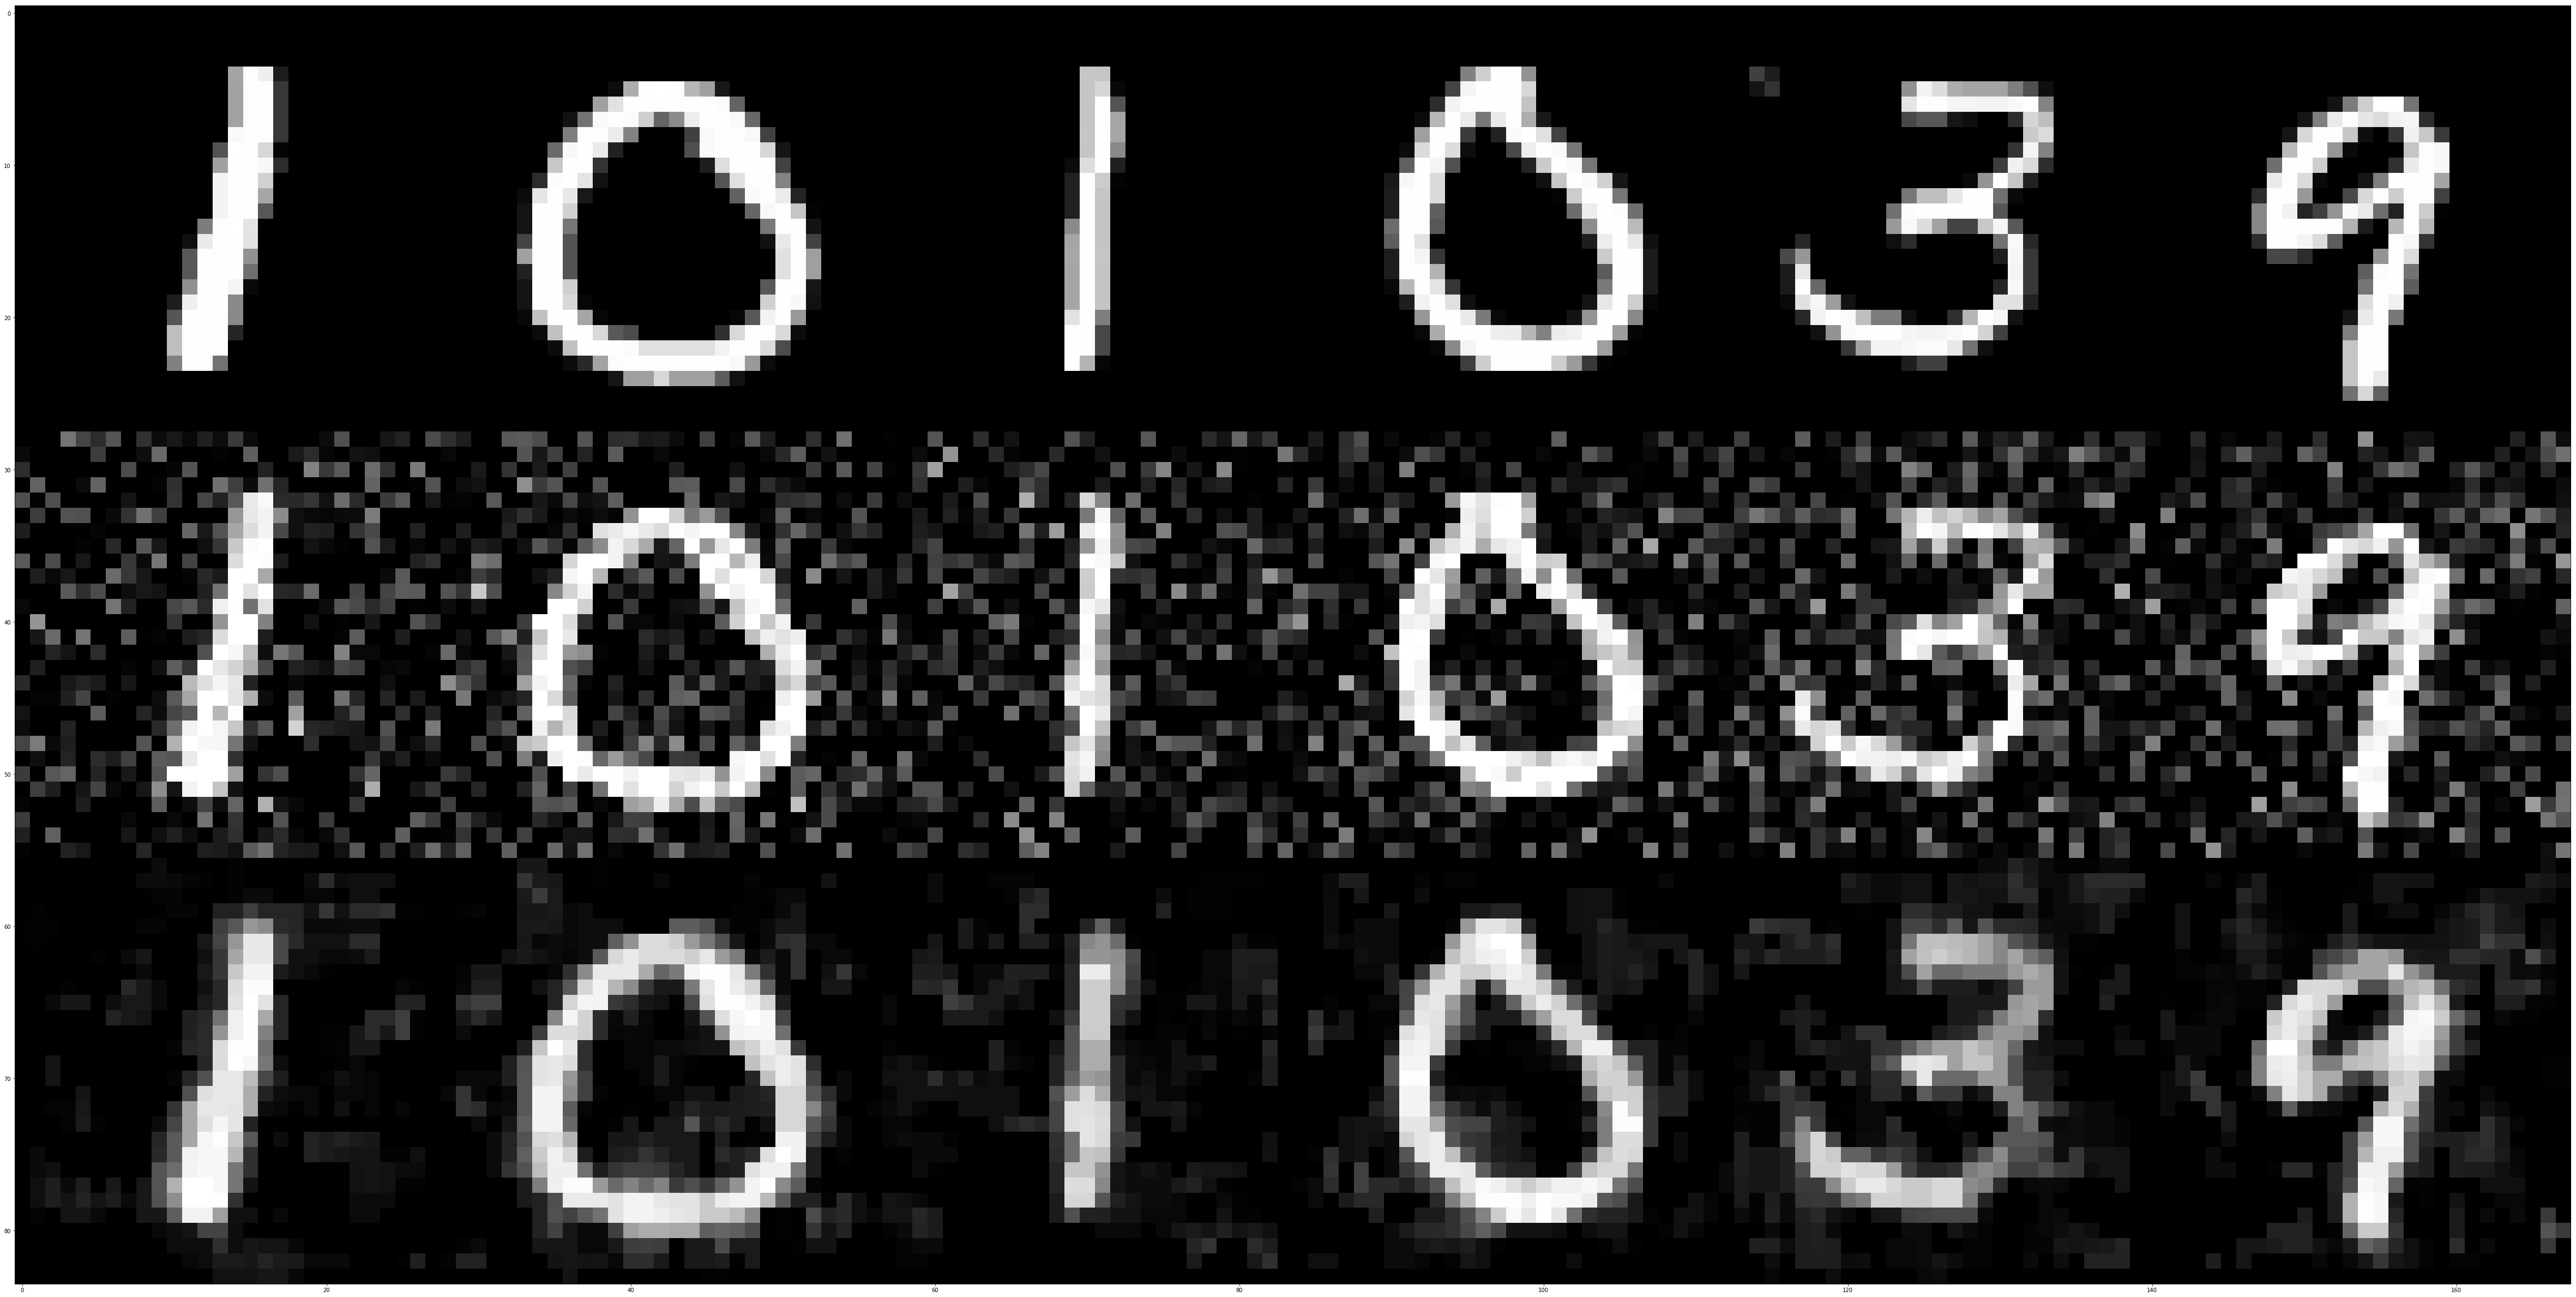

In [17]:
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,train_num,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show() 

# Create encoder and decoder and show their construction

In [35]:
def create_encoder():
    noise = Input(shape=(28,28,1))
    x = Conv2D(32,(3, 3), padding='valid',activation='relu')(noise)
    x = Conv2D(32,(3, 3), padding='valid',activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64,(3, 3), padding='valid',activation='relu')(x)
    x = Conv2D(64,(3, 3), padding='valid',activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64,(3, 3), padding='valid',activation='relu')(x)
    return Model(noise,x)

def create_decoder():
    feature = Input(shape=(2,2,64))
    x = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(feature)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64,(3, 3), padding='same',activation='relu')(x)
    x = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(x)
    x = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(32,(3, 3), padding='same',activation='relu')(x)
    x = Conv2DTranspose(32,(3, 3), padding='valid',activation='relu')(x)
    x = Conv2DTranspose(1,(3, 3), padding='valid',activation='relu')(x)
    return Model(feature,x)

In [36]:
encoder=create_encoder()
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [37]:
decoder = create_decoder()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 4, 4, 64)          36928     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 12, 12, 64)        36928     
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 24, 24, 64)        0         
__________

# Merge them to get autoencoder

In [38]:
noise = Input(shape=(28,28,1))
f = encoder(noise)
x_out = decoder(f)
ae = Model(noise, x_out)
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
model_6 (Model)              (None, 2, 2, 64)          101920    
_________________________________________________________________
model_7 (Model)              (None, 28, 28, 1)         175713    
Total params: 277,633
Trainable params: 277,633
Non-trainable params: 0
_________________________________________________________________


In [42]:
encoder.compile(optimizer='RMSprop', loss='binary_crossentropy')
decoder.compile(optimizer='RMSprop', loss='binary_crossentropy')
ae.compile(optimizer='RMSprop', loss='binary_crossentropy')

ae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

# Test results
First row: original images  
Second row: images add Gaussian noise with 0.2 as stddev  
Third row: Results with second row as inputs  
Forth row: images add Gaussian noise with 0.9 as stddev  
Fifth row: Results with forth row as inputs

In [49]:
digit_size = 28
n=6
figure = np.zeros((digit_size * 5, digit_size * n))
noise_test_09=addNoise(x_test,0.9)

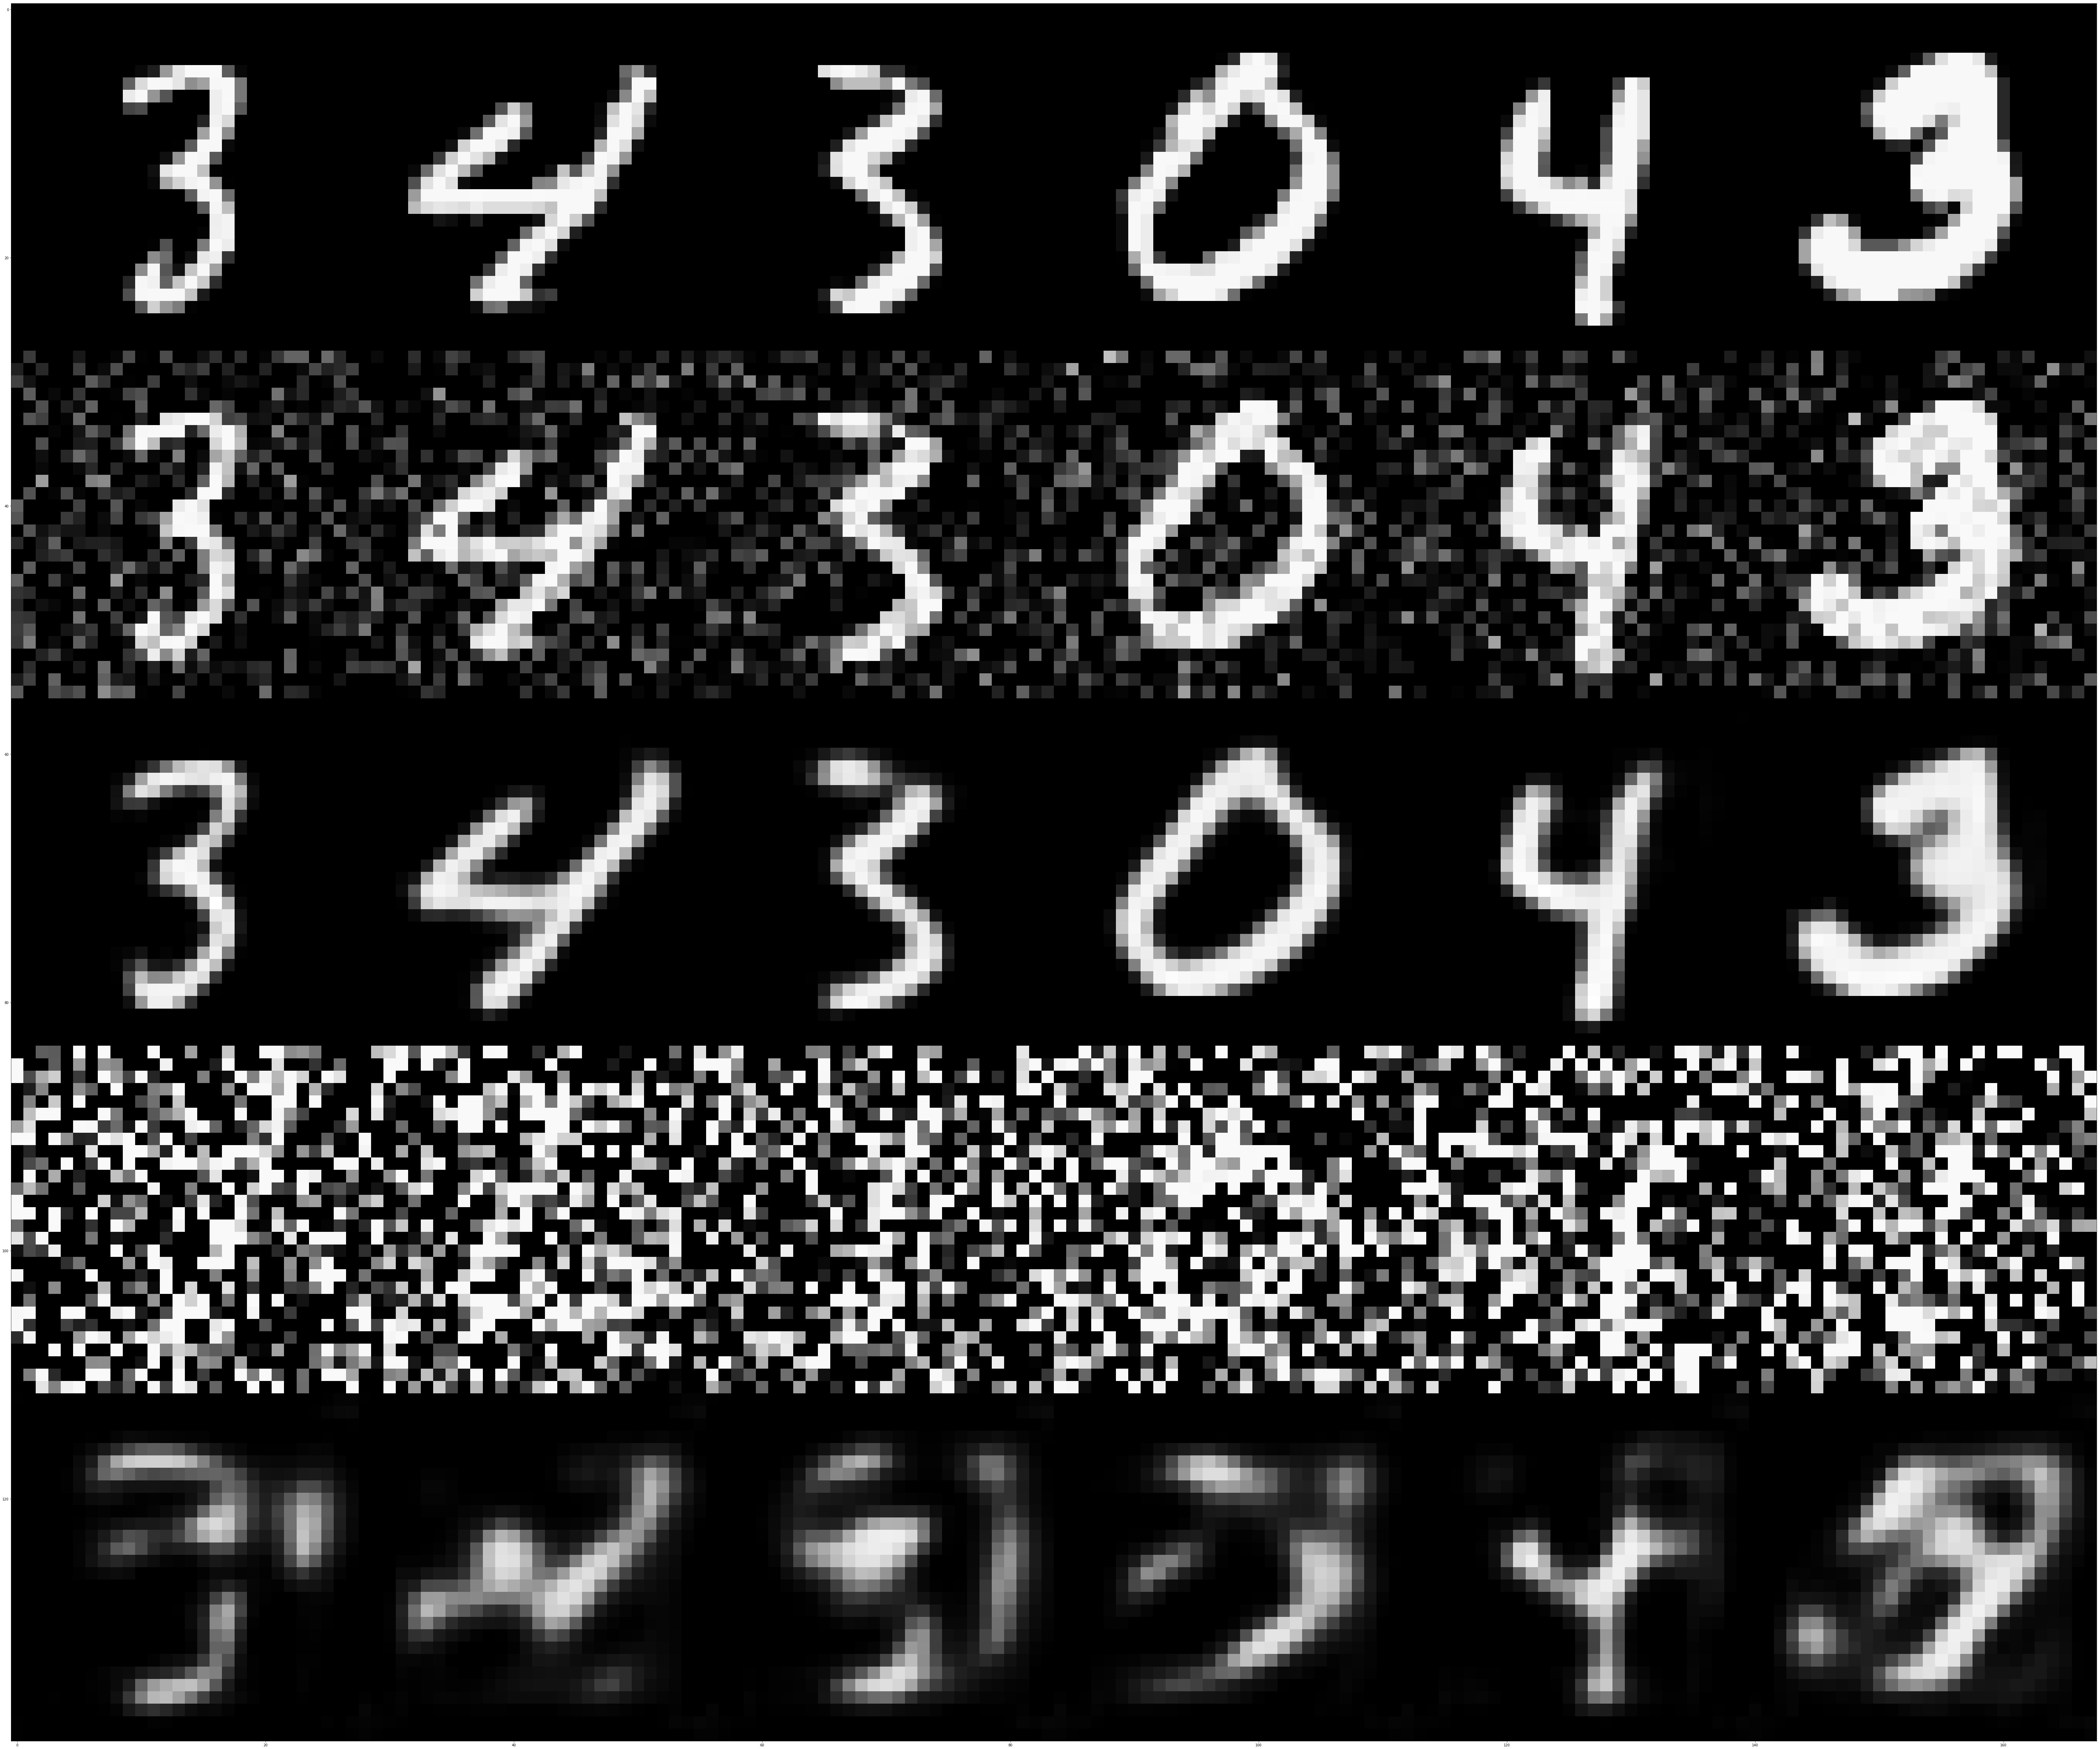

In [50]:
showidx=np.random.randint(0,test_num,n_images)
x_out=ae.predict(noise_test[showidx])
x_out_09=ae.predict(noise_test_09[showidx])
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = np.reshape(noise_test_09[i], [28, 28])
    figure[28 * 4: 28 * 5,i *28: (i + 1) * 28] = np.reshape(x_out_09[i], [28, 28])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_ae.png')
plt.show()